## Tutorial 7 - Lift + Cruise eVTOL Aircraft Simulation
Welcome to this tutorial on simulating a lift + cruise eVTOL aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [1]:
#----------------------------------------------------------------------
#   Imports
# ---------------------------------------------------------------------
import RCAIDE
from RCAIDE.Framework.Core import Units 
from RCAIDE.Library.Methods.Geometry.Planform                                  import wing_segmented_planform   
from RCAIDE.Library.Methods.Weights.Correlation_Buildups.Propulsion            import compute_motor_weight
from RCAIDE.Library.Methods.Propulsors.Converters.DC_Motor                     import design_motor
from RCAIDE.Library.Methods.Performance                                        import estimate_stall_speed
from RCAIDE.Library.Methods.Propulsors.Converters.Rotor                        import design_propeller ,design_lift_rotor 
from RCAIDE.Library.Methods.Weights.Physics_Based_Buildups.Electric            import converge_physics_based_weight_buildup
from RCAIDE.Library.Methods.Weights.Moment_of_Inertia                          import compute_aircraft_moment_of_inertia
from RCAIDE.Library.Methods.Weights.Center_of_Gravity                          import compute_vehicle_center_of_gravity 
from RCAIDE.Library.Plots                                                      import * 
from RCAIDE import  load 
from RCAIDE import  save  
 
import os
import numpy as np 
from copy import deepcopy     
import matplotlib.pyplot as plt 
import  pickle  

## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.

---

In [2]:

def vehicle_setup() :

    
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    airfoil_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator 
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties ########################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
         
    vehicle               = RCAIDE.Vehicle()
    vehicle.tag           = 'Lift_Cruise'
    vehicle.configuration = 'eVTOL'
    
    # mass properties 
    vehicle.mass_properties.max_takeoff       = 2700 
    vehicle.mass_properties.takeoff           = vehicle.mass_properties.max_takeoff
    vehicle.mass_properties.operating_empty   = vehicle.mass_properties.max_takeoff
    vehicle.flight_envelope.ultimate_load     = 5.7   
    vehicle.flight_envelope.limit_load        = 3.  
    vehicle.passengers                        = 5 
        
    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
    wing                          = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                      = 'main_wing'  
    wing.aspect_ratio             = 8.95198  # will  be overwritten
    wing.sweeps.quarter_chord     = 0.0  
    wing.thickness_to_chord       = 0.14 
    wing.taper                    = 0.292
    wing.spans.projected          = 11.82855
    wing.chords.root              = 1.75
    wing.total_length             = 1.75
    wing.chords.tip               = 1.0
    wing.chords.mean_aerodynamic  = 1.5
    wing.dihedral                 = 0.0  
    wing.areas.reference          = 15.629
    wing.twists.root              = 4. * Units.degrees
    wing.twists.tip               = 0. 
    wing.origin                   = [[1.5, 0., 0.991]]
    wing.aerodynamic_center       = [ 1.567, 0., 0.991]    
    wing.winglet_fraction         = 0.0  
    wing.symmetric                = True
    wing.vertical                 = False
    airfoil                       = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.coordinate_file       = airfoil_path + 'Airfoils' + separator + 'NACA_63_412.txt'
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_1'   
    segment.percent_span_location = 0.0
    segment.twist                 = 4. * Units.degrees 
    segment.root_chord_percent    = 1. 
    segment.dihedral_outboard     = 8 * Units.degrees
    segment.sweeps.quarter_chord  = 0.9  * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)               
    
    # Segment                                   
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_2'    
    segment.percent_span_location = 3.5/wing.spans.projected
    segment.twist                 = 3. * Units.degrees 
    segment.root_chord_percent    = 1.4000/1.7500
    segment.dihedral_outboard     = 0.0 * Units.degrees
    segment.sweeps.quarter_chord  = 1.27273 * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)               
     
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_3'   
    segment.percent_span_location = 11.3/wing.spans.projected 
    segment.twist                 = 2.0 * Units.degrees 
    segment.root_chord_percent    = 1.000/1.7500
    segment.dihedral_outboard     = 35.000* Units.degrees 
    segment.sweeps.quarter_chord  = 45.000* Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)     
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_4'   
    segment.percent_span_location = 11.6/wing.spans.projected 
    segment.twist                 = 0.0 * Units.degrees 
    segment.root_chord_percent    = 0.9/1.7500
    segment.dihedral_outboard     = 60. * Units.degrees 
    segment.sweeps.quarter_chord  = 70.0 * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)  
    
    # Segment                                  
    segment                       = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                   = 'Section_5'   
    segment.percent_span_location = 1.0
    segment.twist                 = 0.0 * Units.degrees 
    segment.root_chord_percent    = 0.35/1.7500
    segment.dihedral_outboard     = 0  * Units.degrees 
    segment.sweeps.quarter_chord  = 0  * Units.degrees 
    segment.thickness_to_chord    = 0.16  
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)                 
    
    
    # compute reference properties 
    wing_segmented_planform(wing, overwrite_reference = True )  
    vehicle.reference_area        = wing.areas.reference  
    wing.areas.wetted             = wing.areas.reference  * 2 
    wing.areas.exposed            = wing.areas.reference  * 2  

                                          
    # control surfaces ------------------------------------------- 
    flap                          = RCAIDE.Library.Components.Wings.Control_Surfaces.Flap()
    flap.tag                      = 'flap'
    flap.span_fraction_start      = 0.2
    flap.span_fraction_end        = 0.5
    flap.deflection               = 0.0 * Units.degrees 
    flap.chord_fraction           = 0.20
    wing.append_control_surface(flap)  
    

    aileron                       = RCAIDE.Library.Components.Wings.Control_Surfaces.Aileron()
    aileron.tag                   = 'aileron'
    aileron.span_fraction_start   = 0.7
    aileron.span_fraction_end     = 0.9 
    aileron.deflection            = 0.0 * Units.degrees
    aileron.chord_fraction        = 0.2
    wing.append_control_surface(aileron)      

        
    # add to vehicle 
    vehicle.append_component(wing)   
    
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    #   Horizontal Tail
    #------------------------------------------------------------------------------------------------------------------------------------
    wing                          = RCAIDE.Library.Components.Wings.Horizontal_Tail() 
    wing.aspect_ratio             = 3.04444
    wing.sweeps.quarter_chord     = 17. * Units.degrees
    wing.thickness_to_chord       = 0.12 
    wing.spans.projected          = 2.71805
    wing.chords.root              = 0.94940
    wing.total_length             = 0.94940
    wing.chords.tip               = 0.62731 
    wing.chords.mean_aerodynamic  = 0.809 
    wing.dihedral                 = 20 *Units.degrees
    wing.taper                    = wing.chords.tip / wing.chords.root 
    wing.areas.reference          = 2.14279
    wing.areas.wetted             = 2.14279   * 2
    wing.areas.exposed            = 2.14279   * 2
    wing.twists.root              = 0.0
    wing.twists.tip               = 0.0
    wing.origin                   = [[  5.374 ,0.0 ,  0.596]]
    wing.aerodynamic_center       = [   5.374, 0.0,   0.596] 
    wing.winglet_fraction         = 0.0 
    wing.symmetric                = True
    

    elevator                              = RCAIDE.Library.Components.Wings.Control_Surfaces.Elevator()
    elevator.tag                          = 'elevator'
    elevator.span_fraction_start          = 0.6
    elevator.span_fraction_end            = 0.9
    elevator.deflection                   = 0.0  * Units.deg
    elevator.chord_fraction               = 0.4
    wing.append_control_surface(elevator)       
    

    rudder                                = RCAIDE.Library.Components.Wings.Control_Surfaces.Rudder()
    rudder.tag                            = 'rudder'
    rudder.span_fraction_start            = 0.1
    rudder.span_fraction_end              = 0.5
    rudder.deflection                     = 0.0  * Units.deg
    rudder.chord_fraction                 = 0.4
    wing.append_control_surface(rudder) 
    
        
    # add to vehicle 
    vehicle.append_component(wing)     
      
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##########################################################   Fuselage  ############################################################   
    #------------------------------------------------------------------------------------------------------------------------------------ 
    fuselage                                    = RCAIDE.Library.Components.Fuselages.Fuselage()
    fuselage.tag                                = 'fuselage' 
    fuselage.seats_abreast                      = 2.  
    fuselage.seat_pitch                         = 3.  
    fuselage.fineness.nose                      = 0.88   
    fuselage.fineness.tail                      = 1.13   
    fuselage.lengths.nose                       = 0.5  
    fuselage.lengths.tail                       = 1.5
    fuselage.lengths.cabin                      = 4.46 
    fuselage.lengths.total                      = 6.46
    fuselage.width                              = 5.85 * Units.feet      # change 
    fuselage.heights.maximum                    = 4.65 * Units.feet      # change 
    fuselage.heights.at_quarter_length          = 3.75 * Units.feet      # change 
    fuselage.heights.at_wing_root_quarter_chord = 4.65 * Units.feet      # change 
    fuselage.heights.at_three_quarters_length   = 4.26 * Units.feet      # change 
    fuselage.areas.wetted                       = 236. * Units.feet**2   # change 
    fuselage.areas.front_projected              = 0.14 * Units.feet**2   # change 
    fuselage.effective_diameter                 = 1.276     # change 
    fuselage.differential_pressure              = 0. 
    
    # Segment  
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                                 = 'segment_0'    
    segment.percent_x_location                  = 0.0 
    segment.percent_z_location                  = 0.     # change  
    segment.height                              = 0.049 
    segment.width                               = 0.032 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'   
    segment.percent_x_location                  = 0.10912/fuselage.lengths.total 
    segment.percent_z_location                  = 0.00849
    segment.height                              = 0.481 
    segment.width                               = 0.553 
    fuselage.append_segment(segment)           
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'   
    segment.percent_x_location                  = 0.47804/fuselage.lengths.total
    segment.percent_z_location                  = 0.02874
    segment.height                              = 1.00
    segment.width                               = 0.912 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                            
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'   
    segment.percent_x_location                  = 0.161  
    segment.percent_z_location                  = 0.04348  
    segment.height                              = 1.41
    segment.width                               = 1.174  
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'   
    segment.percent_x_location                  = 0.284 
    segment.percent_z_location                  = 0.05435 
    segment.height                              = 1.62
    segment.width                               = 1.276  
    fuselage.append_segment(segment)              
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'   
    segment.percent_x_location                  = 3.43026/fuselage.lengths.total
    segment.percent_z_location                  = 0.31483/fuselage.lengths.total 
    segment.height                              = 1.409
    segment.width                               = 1.121 
    fuselage.append_segment(segment)                     
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'   
    segment.percent_x_location                  = 4.20546/fuselage.lengths.total
    segment.percent_z_location                  = 0.32216/fuselage.lengths.total
    segment.height                              = 1.11
    segment.width                               = 0.833
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'   
    segment.percent_x_location                  = 4.99358/fuselage.lengths.total
    segment.percent_z_location                  = 0.37815/fuselage.lengths.total
    segment.height                              = 0.78
    segment.width                               = 0.512 
    fuselage.append_segment(segment)                  
                                                
    # Segment                                             
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'   
    segment.percent_x_location                  = 1.
    segment.percent_z_location                  = 0.55/fuselage.lengths.total
    segment.height                              = 0.195  
    segment.width                               = 0.130 
    fuselage.append_segment(segment)                   
                                                
    vehicle.append_component(fuselage) 
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##########################################################  Booms  ################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------          
    boom                                    = RCAIDE.Library.Components.Booms.Boom()
    boom.tag                                = 'boom_1r'
    boom.configuration                      = 'boom'  
    boom.origin                             = [[   0.036, 1.950,  1]]  
    boom.seats_abreast                      = 0.  
    boom.seat_pitch                         = 0.0 
    boom.fineness.nose                      = 0.950   
    boom.fineness.tail                      = 1.029   
    boom.lengths.nose                       = 0.2 
    boom.lengths.tail                       = 0.2
    boom.lengths.cabin                      = 4.15
    boom.lengths.total                      = 4.2
    boom.width                              = 0.15 
    boom.heights.maximum                    = 0.15  
    boom.heights.at_quarter_length          = 0.15  
    boom.heights.at_three_quarters_length   = 0.15 
    boom.heights.at_wing_root_quarter_chord = 0.15 
    boom.areas.wetted                       = 0.018
    boom.areas.front_projected              = 0.018 
    boom.effective_diameter                 = 0.15  
    boom.differential_pressure              = 0.  
    boom.symmetric                          = True 
    boom.index                              = 1
    
    # Segment  
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment() 
    segment.tag                       = 'segment_1'   
    segment.percent_x_location        = 0.
    segment.percent_z_location        = 0.0 
    segment.height                    = 0.05  
    segment.width                     = 0.05   
    boom.append_segment(segment)           
    
    # Segment                                   
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_2'   
    segment.percent_x_location        = 0.03
    segment.percent_z_location        = 0. 
    segment.height                    = 0.15 
    segment.width                     = 0.15 
    boom.append_segment(segment) 
    
    # Segment                                   
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_3'    
    segment.percent_x_location        = 0.97
    segment.percent_z_location        = 0. 
    segment.height                    = 0.15
    segment.width                     = 0.15
    boom.append_segment(segment)           
    
    # Segment                                  
    segment                           = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                       = 'segment_4'   
    segment.percent_x_location        = 1.   
    segment.percent_z_location        = 0.   
    segment.height                    = 0.05   
    segment.width                     = 0.05   
    boom.append_segment(segment)           
    
    # add to vehicle
    vehicle.append_component(boom)   
    
    # add left long boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin[0][1] = -boom.origin[0][1]
    boom.tag          = 'boom_1l' 
    vehicle.append_component(boom)         
     
    # add left long boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110,    4.891,   1.050]] 
    boom.tag          = 'boom_2r' 
    boom.lengths.total                      = 4.16
    vehicle.append_component(boom)  
     
    # add inner left boom 
    boom              = deepcopy(vehicle.booms.boom_1r)
    boom.origin       = [[     0.110, -  4.891,    1.050 ]]   
    boom.lengths.total                      = 4.16
    boom.tag          = 'boom_2l' 
    vehicle.append_component(boom)      
         
    sys                            = RCAIDE.Library.Components.Systems.System()
    sys.mass_properties.mass       = 5 # kg   
    vehicle.append_component(sys)    
   
    #------------------------------------------------------------------------------------------------------------------------------------
    # ########################################################  Energy Network  ######################################################### 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    network                                                = RCAIDE.Framework.Networks.Electric()   
    
    #==================================================================================================================================== 
    # Forward Bus
    #====================================================================================================================================  
    cruise_bus                           = RCAIDE.Library.Components.Energy.Distributors.Electrical_Bus() 
    cruise_bus.tag                       = 'cruise_bus' 
    cruise_bus.number_of_battery_modules =  1     
     
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Energy.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'cruise_bus_battery'
    battery_module.electrical_configuration.series                     = 140  
    battery_module.electrical_configuration.parallel                   = 60  
    battery_module.geometrtic_configuration.normal_count               = 140  
    battery_module.geometrtic_configuration.parallel_count             = 60  
    for _ in range( cruise_bus.number_of_battery_modules):
        cruise_bus.battery_modules.append(deepcopy(battery_module))    
    cruise_bus.initialize_bus_properties()
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Forward Bus Propulsors  
    #------------------------------------------------------------------------------------------------------------------------------------       
    # Define Forward Propulsor Container 
    cruise_propulsor_1                                     = RCAIDE.Library.Components.Propulsors.Electric_Rotor()
    cruise_propulsor_1.tag                                 = 'cruise_propulsor_1'  
    cruise_propulsor_1.wing_mounted                        = False       
                 
    # Electronic Speed Controller                     
    propeller_esc                                          = RCAIDE.Library.Components.Energy.Modulators.Electronic_Speed_Controller() 
    propeller_esc.efficiency                               = 0.95  
    propeller_esc.origin                                   = [[6.583, 1.300,  1.092 ]] 
    propeller_esc.tag                                      = 'propeller_esc_1' 
    cruise_propulsor_1.electronic_speed_controller         = propeller_esc      
    
    # Propeller 
    g                                                      = 9.81                                   # gravitational acceleration 
    speed_of_sound                                         = 340                                    # speed of sound 
    Hover_Load                                             = vehicle.mass_properties.takeoff*g *1.1 # hover load   
            
    propeller                                              = RCAIDE.Library.Components.Propulsors.Converters.Propeller()
    propeller.number_of_blades                             = 3
    propeller.tag                                          = 'propeller_1'  
    propeller.origin                                       = [[6.583, 1.300,  1.092 ]] 
    propeller.tip_radius                                   = 1.15  
    propeller.hub_radius                                   = 0.1 * propeller.tip_radius  
    propeller.cruise.design_freestream_velocity            = 130.* Units['mph'] 
    propeller.cruise.design_tip_mach                       = 0.65
    propeller.cruise.design_angular_velocity               = propeller.cruise.design_tip_mach *speed_of_sound/propeller.tip_radius
    propeller.cruise.design_Cl                             = 0.7
    propeller.cruise.design_altitude                       = 1500 * Units.feet
    propeller.cruise.design_thrust                         = 3150
    propeller.rotation                                     = 1
    propeller.variable_pitch                               = True  
    airfoil                                                = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.coordinate_file                                = airfoil_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                                    = [airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    propeller.append_airfoil(airfoil)                     
    propeller.airfoil_polar_stations                       = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
    propeller                                              = design_propeller(propeller)   
    cruise_propulsor_1.rotor                               = propeller    
                
    # Propeller Motor              
    propeller_motor                                        = RCAIDE.Library.Components.Propulsors.Converters.DC_Motor()
    propeller_motor.efficiency                             = 0.95
    propeller_motor.tag                                    = 'propeller_motor_1'  
    propeller_motor.origin                                 = [[6.583, 1.300,  1.092 ]] 
    propeller_motor.nominal_voltage                        = cruise_bus.voltage  
    propeller_motor.no_load_current                        = 0.001
    propeller_motor.wing_tag                               = 'horizontal_tail'
    propeller_motor.rotor_radius                           = propeller.tip_radius
    propeller_motor.design_torque                          = propeller.cruise.design_torque
    propeller_motor.angular_velocity                       = propeller.cruise.design_angular_velocity/propeller_motor.gear_ratio  
    design_motor(propeller_motor)  
    propeller_motor.mass_properties.mass                   = compute_motor_weight(propeller_motor)  
    cruise_propulsor_1.motor                               = propeller_motor 
      
    # rear propeller nacelle 
    propeller_nacelle                = RCAIDE.Library.Components.Nacelles.Stack_Nacelle()
    propeller_nacelle.tag            = 'propeller_nacelle'
    propeller_nacelle.length         = 1.24
    propeller_nacelle.diameter       = 0.4    
    propeller_nacelle.origin        = [[5.583,  1.300 ,    1.092]]
    propeller_nacelle.flow_through   = False  
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_1'
    nac_segment.percent_x_location = 0.0  
    nac_segment.height             = 0.0
    nac_segment.width              = 0.0
    propeller_nacelle.append_segment(nac_segment)    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_2'
    nac_segment.percent_x_location = 0.10/propeller_nacelle.length
    nac_segment.height             = 0.2
    nac_segment.width              = 0.2
    propeller_nacelle.append_segment(nac_segment)    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_2'
    nac_segment.percent_x_location = 0.15 /propeller_nacelle.length 
    nac_segment.height             = 0.25
    nac_segment.width              = 0.25
    propeller_nacelle.append_segment(nac_segment)    
    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_4'
    nac_segment.percent_x_location = 0.2/propeller_nacelle.length  
    nac_segment.height             = 0.3
    nac_segment.width              = 0.3
    propeller_nacelle.append_segment(nac_segment)    
    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_5'
    nac_segment.percent_x_location = 0.25/propeller_nacelle.length  
    nac_segment.height             = 0.35
    nac_segment.width              = 0.35
    propeller_nacelle.append_segment(nac_segment)    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_6'
    nac_segment.percent_x_location = 0.5/propeller_nacelle.length 
    nac_segment.height             = 0.4
    nac_segment.width              = 0.4
    propeller_nacelle.append_segment(nac_segment)    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_7'
    nac_segment.percent_x_location = 0.75/propeller_nacelle.length
    nac_segment.height             = 0.35
    nac_segment.width              = 0.35
    propeller_nacelle.append_segment(nac_segment)        
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_8'
    nac_segment.percent_x_location = 0.98/propeller_nacelle.length
    nac_segment.height             = 0.3
    nac_segment.width              = 0.3
    propeller_nacelle.append_segment(nac_segment)    
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_9'
    nac_segment.percent_x_location = 1.0  
    nac_segment.height             = 0.0
    nac_segment.width              = 0.0
    propeller_nacelle.append_segment(nac_segment)      
    cruise_propulsor_1.nacelle = propeller_nacelle   
    network.propulsors.append(cruise_propulsor_1)
      
    # make and append copy of forward propulsor (efficient coding)    
    cruise_propulsor_2                             = deepcopy(cruise_propulsor_1)
    cruise_propulsor_2.tag                         = 'cruise_propulsor_2' 
    cruise_propulsor_2.rotor.origin                = [[6.583, -1.300,  1.092 ]]   
    propeller_nacelle_2                            = deepcopy(propeller_nacelle)
    propeller_nacelle_2.tag                        = 'propeller_nacelle_2' 
    propeller_nacelle_2.origin                     = [[5.583, - 1.300,     1.092]]
    cruise_propulsor_2.nacelle                     = propeller_nacelle_2
    network.propulsors.append(cruise_propulsor_2) 
    cruise_bus.assigned_propulsors = [['cruise_propulsor_1','cruise_propulsor_2' ]]
        
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------     
    # Payload   
    payload                        = RCAIDE.Library.Components.Systems.Avionics()
    payload.power_draw             = 10. # Watts 
    payload.mass_properties.mass   = 1.0 * Units.kg
    cruise_bus.payload             = payload 
    
    # Avionics   
    avionics                       = RCAIDE.Library.Components.Systems.Avionics()
    avionics.power_draw            = 10. # Watts  
    avionics.mass_properties.mass  = 1.0 * Units.kg
    cruise_bus.avionics            = avionics    

    # append forward bus
    network.busses.append(cruise_bus)    
    
        
    #==================================================================================================================================== 
    # Lift Bus 
    #====================================================================================================================================          
    lift_bus                                               = RCAIDE.Library.Components.Energy.Distributors.Electrical_Bus()
    lift_bus.tag                                           = 'lift_bus' 
    lift_bus.number_of_battery_modules =  1     

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus Battery
    #------------------------------------------------------------------------------------------------------------------------------------ 
    battery_module                                                    = RCAIDE.Library.Components.Energy.Sources.Battery_Modules.Lithium_Ion_NMC() 
    battery_module.tag                                                = 'lift_bus_battery'
    battery_module.electrical_configuration.series                    = 140
    battery_module.origin                                             = [[4.2, 0.0, 0.0]]
    battery_module.electrical_configuration.parallel                  = 20 
    battery_module.geometrtic_configuration.normal_count              = 140   
    battery_module.geometrtic_configuration.parallel_count            = 20 
    for _ in range( lift_bus.number_of_battery_modules):
        lift_bus.battery_modules.append(deepcopy(battery_module))
    lift_bus.initialize_bus_properties()

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Lift Propulsors 
    #------------------------------------------------------------------------------------------------------------------------------------    
     
    # Define Lift Propulsor Container 
    lift_propulsor_1                                       = RCAIDE.Library.Components.Propulsors.Electric_Rotor() 
    lift_propulsor_1.wing_mounted                          = True         
              
    # Electronic Speed Controller           
    lift_rotor_esc                                         = RCAIDE.Library.Components.Energy.Modulators.Electronic_Speed_Controller() 
    lift_rotor_esc.efficiency                              = 0.95     
    lift_rotor_esc.origin                                  = [[-0.073 ,  1.950 , 1.2]] 
    lift_propulsor_1.electronic_speed_controller           = lift_rotor_esc 
           
    # Lift Rotor Design              
    lift_rotor                                             = RCAIDE.Library.Components.Propulsors.Converters.Lift_Rotor()  
    lift_rotor.origin                                      = [[-0.073 ,  1.950 , 1.2]] 
    lift_rotor.active                                      = True          
    lift_rotor.tip_radius                                  = 2.8/2
    lift_rotor.hub_radius                                  = 0.1 
    lift_rotor.number_of_blades                            = 3     
    lift_rotor.hover.design_altitude                       = 40 * Units.feet  
    lift_rotor.hover.design_thrust                         = Hover_Load/8
    lift_rotor.hover.design_freestream_velocity            = np.sqrt(lift_rotor.hover.design_thrust/(2*1.2*np.pi*(lift_rotor.tip_radius**2)))  
    lift_rotor.oei.design_altitude                         = 40 * Units.feet  
    lift_rotor.oei.design_thrust                           = Hover_Load/7  
    lift_rotor.oei.design_freestream_velocity              = np.sqrt(lift_rotor.oei.design_thrust/(2*1.2*np.pi*(lift_rotor.tip_radius**2)))  
    airfoil                                                = RCAIDE.Library.Components.Airfoils.Airfoil()   
    airfoil.coordinate_file                                = airfoil_path + 'Airfoils' + separator + 'NACA_4412.txt'
    airfoil.polar_files                                    = [airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt' ,
                                                             airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt' ,
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_3500000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_5000000.txt',
                                                              airfoil_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_7500000.txt' ]
    lift_rotor.append_airfoil(airfoil)                         
    lift_rotor.airfoil_polar_stations                      = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]  
    design_lift_rotor(lift_rotor)      
            
    lift_propulsor_1.rotor =  lift_rotor          
    
    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Motor  
    #------------------------------------------------------------------------------------------------------------------------------------    
    lift_rotor_motor                                       = RCAIDE.Library.Components.Propulsors.Converters.DC_Motor()
    lift_rotor_motor.efficiency                            = 0.9
    lift_rotor_motor.nominal_voltage                       = lift_bus.voltage*3/4  
    lift_rotor_motor.propeller_radius                      = lift_rotor.tip_radius 
    lift_rotor_motor.no_load_current                       = 0.01   
    lift_rotor_motor.rotor_radius                          = lift_rotor.tip_radius
    lift_rotor_motor.design_torque                         = lift_rotor.hover.design_torque
    lift_rotor_motor.angular_velocity                      = lift_rotor.hover.design_angular_velocity/lift_rotor_motor.gear_ratio  
    design_motor(lift_rotor_motor)
    lift_rotor_motor.mass_properties.mass                  = compute_motor_weight(lift_rotor_motor)     
    lift_propulsor_1.motor                                 = lift_rotor_motor
    


    #------------------------------------------------------------------------------------------------------------------------------------               
    # Lift Rotor Nacelle
    #------------------------------------------------------------------------------------------------------------------------------------     
    nacelle                           = RCAIDE.Library.Components.Nacelles.Nacelle() 
    nacelle.length                    = 0.45
    nacelle.diameter                  = 0.3
    nacelle.orientation_euler_angles  = [0,-90*Units.degrees,0.]    
    nacelle.flow_through              = False    
    nacelle.origin                    = [[  -0.073,  1.950, 1.2]]
    lift_propulsor_1.nacelle          =  nacelle  

 
    # Front Rotors Locations 
    origins = [[  -0.073,  1.950, 1.2], [-0.073  , -1.950  , 1.2],[ 4.440 ,  1.950 , 1.2], [ 4.440  , -1.950  , 1.2],
               [ 0.219 ,  4.891 , 1.2], [ 0.219  , - 4.891 , 1.2], [ 4.196 ,  4.891 , 1.2], [ 4.196  , - 4.891 , 1.2]]
    orientation_euler_angles = [[10.0*Units.degrees,np.pi/2.,0.],[-10.0* Units.degrees,np.pi/2.,0.], [10.0* Units.degrees,np.pi/2.,0.], [-10.0* Units.degrees,np.pi/2.,0.], 
                                [10.0* Units.degrees,np.pi/2.,0.], [-10.0* Units.degrees,np.pi/2.,0.], [10.0* Units.degrees,np.pi/2.,0.], [-10.0* Units.degrees,np.pi/2.,0.]] # vector of angles defining default orientation of rotor
    
    
    assigned_propulsor_list = []        
    for i in range(len(origins)): 
        propulsor_i                                       = deepcopy(lift_propulsor_1)
        propulsor_i.tag                                   = 'lift_propulsor_' + str(i + 1)
        propulsor_i.rotor.tag                             = 'lift_rotor_' + str(i + 1) 
        propulsor_i.rotor.origin                          = [origins[i]] 
        propulsor_i.rotor.orientation_euler_angle         = orientation_euler_angles[i]
        propulsor_i.motor.tag                             = 'lift_rotor_motor_' + str(i + 1)   
        propulsor_i.motor.origin                          = [origins[i]]  
        propulsor_i.electronic_speed_controller.tag       = 'lift_rotor_esc_' + str(i + 1)  
        propulsor_i.electronic_speed_controller.origin    = [origins[i]]  
        propulsor_i.nacelle.tag                           = 'lift_rotor_nacelle_' + str(i + 1)  
        propulsor_i.nacelle.origin                        = [origins[i]]    
        network.propulsors.append(propulsor_i)  
        assigned_propulsor_list.append(propulsor_i.tag) 
    lift_bus.assigned_propulsors = [assigned_propulsor_list]

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Additional Bus Loads
    #------------------------------------------------------------------------------------------------------------------------------------            
    # Payload   
    payload                                                 = RCAIDE.Library.Components.Systems.Avionics()
    payload.power_draw                                      = 10. # Watts 
    payload.mass_properties.mass                            = 1.0 * Units.kg
    lift_bus.payload                                        = payload 
                             
    # Avionics                            
    avionics                                                = RCAIDE.Library.Components.Systems.Avionics()
    avionics.power_draw                                     = 10. # Watts  
    avionics.mass_properties.mass                           = 1.0 * Units.kg
    lift_bus.avionics                                       = avionics    

   
    network.busses.append(lift_bus)       
        
    # append energy network 
    vehicle.append_energy_network(network) 
     
    #------------------------------------------------------------------------------------------------------------------------------------
    # ##################################   Determine Vehicle Mass Properties Using Physic Based Methods  ################################ 
    #------------------------------------------------------------------------------------------------------------------------------------   
    converged_vehicle, breakdown = converge_physics_based_weight_buildup(vehicle)  
    print(breakdown)

    # ------------------------------------------------------------------
    #   CG Location
    # ------------------------------------------------------------------    
    _ , _ =  compute_vehicle_center_of_gravity(converged_vehicle) 
    CG_location  = converged_vehicle.mass_properties.center_of_gravity
    
    # ------------------------------------------------------------------
    #   Operating Aircraft MOI
    # ------------------------------------------------------------------    
    _, _ = compute_aircraft_moment_of_inertia(converged_vehicle, CG_location)    

    return converged_vehicle



## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---


### 2. Remaining Configurations

The remaining configurations, such as **forward**, **transition**, and **vertical**, follow a similar pattern:

- Forward
- Transition
- Vertical

Each configuration is built upon the previous one or the base configuration, ensuring modularity and easy customization.

---

In [3]:
def configs_setup(vehicle): 

    configs = RCAIDE.Library.Components.Configs.Config.Container()

    base_config                                                       = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag                                                   = 'base'     
    configs.append(base_config) 

    forward_config                                                    = RCAIDE.Library.Components.Configs.Config(vehicle)
    forward_config.tag                                                = 'forward_flight'  
    forward_config.networks.electric.busses['lift_bus'].active        = False  
    configs.append(forward_config)  

    transition_config                                                 = RCAIDE.Library.Components.Configs.Config(vehicle)
    transition_config.tag                                             = 'transition_flight'    
    configs.append(transition_config)
    

    vertical_config                                                   = RCAIDE.Library.Components.Configs.Config(vehicle)
    vertical_config.tag                                               = 'vertical_flight'  
    vertical_config.networks.electric.busses['cruise_bus'].active = False  
    configs.append(vertical_config)   
     
    return configs

 


## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---

In [4]:

def base_analysis(vehicle):

     # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle() 
    
    # ------------------------------------------------------------------
    #  Weights
    weights         = RCAIDE.Framework.Analyses.Weights.Weights_EVTOL()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics          = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle = vehicle 
    analyses.append(aerodynamics)   

    # ------------------------------------------------------------------
    #  Stability Analysis
    stability         = RCAIDE.Framework.Analyses.Stability.Vortex_Lattice_Method() 
    stability.vehicle = vehicle 
    analyses.append(stability)    

    # ------------------------------------------------------------------
    #  Energy
    energy          = RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle  = vehicle 
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses


## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

## 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [5]:
def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses


## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [6]:

# ------------------------------------------------------------------
#   Baseline Mission Setup
# ------------------------------------------------------------------
def mission_setup(analyses): 
    
    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------

    mission     = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'baseline_mission' 
    
    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments

    # base segment           
    base_segment  = Segments.Segment()
    
    # VSTALL Calculation  
    vehicle_mass   = analyses.base.aerodynamics.vehicle.mass_properties.max_takeoff
    reference_area = analyses.base.aerodynamics.vehicle.reference_area 
    Vstall         = estimate_stall_speed(vehicle_mass,reference_area,altitude = 0.0,maximum_lift_coefficient = 1.2)      
     
    #------------------------------------------------------------------------------------------------------------------------------------  
    # Vertical Climb 
    #------------------------------------------------------------------------------------------------------------------------------------  
    segment     = Segments.Vertical_Flight.Climb(base_segment)
    segment.tag = "Vertical_Climb"   
    segment.analyses.extend( analyses.vertical_flight )  
    segment.altitude_start                                = 0.0  * Units.ft  
    segment.altitude_end                                  = 50.  * Units.ft   
    segment.initial_battery_state_of_charge               = 1.0 
    segment.climb_rate                                    = 500. * Units['ft/min'] 
            
    # define flight dynamics to model  
    segment.flight_dynamics.force_z                       = True 
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['lift_propulsor_1','lift_propulsor_2','lift_propulsor_3','lift_propulsor_4',
                                                              'lift_propulsor_5','lift_propulsor_6','lift_propulsor_7','lift_propulsor_8']] 
       
    mission.append_segment(segment)
     
 
    #------------------------------------------------------------------------------------------------------------------------------------  
    # High-Speed Climbing Transition 
    #------------------------------------------------------------------------------------------------------------------------------------  
    segment                                               = Segments.Transition.Constant_Acceleration_Constant_Angle_Linear_Climb(base_segment)
    segment.tag                                           = "High_Speed_Climbing_Transition" 
    segment.analyses.extend( analyses.transition_flight)    
    segment.true_course                                   = 0 * Units.degree
    segment.altitude_start                                = 50.0 * Units.ft   
    segment.altitude_end                                  = 500.0 * Units.ft 
    segment.climb_angle                                   = 3     * Units.degrees   
    segment.acceleration                                  = 0.25  * Units['m/s/s'] 
    segment.pitch_initial                                 = 2.    * Units.degrees 
    segment.pitch_final                                   = 7.    * Units.degrees  

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2'],
                                                             ['lift_propulsor_1','lift_propulsor_2','lift_propulsor_3','lift_propulsor_4',
                                                            'lift_propulsor_5','lift_propulsor_6','lift_propulsor_7','lift_propulsor_8']]
    mission.append_segment(segment) 
   
  

    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Second Climb
    #------------------------------------------------------------------------------------------------------------------------------------  
    segment                                               = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                                           = "Climb"  
    segment.analyses.extend( analyses.forward_flight)   
    segment.altitude_start                                = 500.0 * Units.ft   
    segment.altitude_end                                  = 1000. * Units.ft   
    segment.climb_rate                                    = 300.  * Units['ft/min'] 
    segment.air_speed_end                                 = 110    * Units['mph']  
              
    # define flight dynamics to model   
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2']] 
    segment.assigned_control_variables.body_angle.active             = True                
                 
    mission.append_segment(segment)  

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Cruise 
    #------------------------------------------------------------------------------------------------------------------------------------  
    segment                                               = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag                                           = "Cruise"  
    segment.analyses.extend( analyses.forward_flight )                  
    segment.altitude                                      = 1000.0 * Units.ft  
    segment.air_speed                                     = 110.  * Units['mph']  
    segment.distance                                      = 40 *Units.nmi    
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2']] 
    segment.assigned_control_variables.body_angle.active             = True                
         
    mission.append_segment(segment)   
    
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Descent
    #------------------------------------------------------------------------------------------------------------------------------------   
    segment                                               = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag                                           = "Descent"  
    segment.analyses.extend(analyses.forward_flight)  
    segment.altitude_start                                = 1000.0 * Units.ft  
    segment.altitude_end                                  = 500. * Units.ft  
    segment.climb_rate                                    = -500.  * Units['ft/min']
    segment.air_speed_start                               = 90 *  Units.kts
    segment.air_speed_end                                 = Vstall        
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2']] 
    segment.assigned_control_variables.body_angle.active             = True                
       
    mission.append_segment(segment)  
       
            
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # High-Speed Descending Transition
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                               = Segments.Transition.Constant_Acceleration_Constant_Angle_Linear_Climb(base_segment)
    segment.tag                                           = "Descending_Transition"  
    segment.analyses.extend( analyses.transition_flight ) 
    segment.altitude_start                                = 500.0 * Units.ft   
    segment.altitude_end                                  = 50.0 * Units.ft   
    segment.climb_angle                                   = 3. * Units.degrees
    segment.acceleration                                  = 0.5 
    segment.pitch_initial                                 = 2  * Units.degrees    
    segment.pitch_final                                   = 5. * Units.degrees   

    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True 
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2'],
                                                             ['lift_propulsor_1','lift_propulsor_2','lift_propulsor_3','lift_propulsor_4',
                                                            'lift_propulsor_5','lift_propulsor_6','lift_propulsor_7','lift_propulsor_8'] ]
        
    mission.append_segment(segment)  

    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Low Speed Approach Transition
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                               = Segments.Transition.Constant_Acceleration_Constant_Pitchrate_Constant_Altitude(base_segment)
    segment.tag                                           = "Low_Speed_Approach_Transition"   
    segment.analyses.extend( analyses.transition_flight ) 
    segment.altitude                                      = 50.  * Units.ft     
    segment.air_speed_start                               = 36.5 * Units['mph'] 
    segment.air_speed_end                                 = 50. * Units['ft/min'] 
    segment.acceleration                                  = -0.25 * Units['m/s/s']    
    segment.pitch_initial                                 = 5.  * Units.degrees  
    segment.pitch_final                                   = 2. * Units.degrees    
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['cruise_propulsor_1','cruise_propulsor_2'],
                                                             ['lift_propulsor_1','lift_propulsor_2','lift_propulsor_3','lift_propulsor_4',
                                                            'lift_propulsor_5','lift_propulsor_6','lift_propulsor_7','lift_propulsor_8']] 
    mission.append_segment(segment)       
    
    #------------------------------------------------------------------------------------------------------------------------------------ 
    # Vertical Descent 
    #------------------------------------------------------------------------------------------------------------------------------------ 
    segment                                               = Segments.Vertical_Flight.Descent(base_segment)
    segment.tag                                           = "Vertical_Descent" 
    segment.analyses.extend( analyses.vertical_flight)     
    segment.altitude_start                                = 50.0 * Units.ft   
    segment.altitude_end                                  = 0.   * Units.ft  
    segment.descent_rate                                  = 300. * Units['ft/min']  
    
    # define flight dynamics to model  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['lift_propulsor_1','lift_propulsor_2','lift_propulsor_3','lift_propulsor_4',
                                                              'lift_propulsor_5','lift_propulsor_6','lift_propulsor_7','lift_propulsor_8']] 
            
    mission.append_segment(segment)  
 
    return mission 



## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [7]:

def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions  

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [8]:
def plot_results(results):  
    
    # Plots fligh conditions 
    plot_flight_conditions(results) 
    
    # Plot arcraft trajectory
    plot_flight_trajectory(results)
    
    # Plot Aerodynamic Coefficients
    plot_aerodynamic_coefficients(results)  
     
    # Plot Aircraft Stability
    plot_longitudinal_stability(results) 
    
    # Plot Aircraft Electronics 
    plot_battery_temperature(results)
    plot_battery_cell_conditions(results) 
    plot_battery_degradation(results) 
    plot_electric_propulsor_efficiencies(results) 
    
    # Plot Propeller Conditions 
    plot_rotor_conditions(results) 
    plot_disc_and_power_loading(results)
     
    # Plot Battery Degradation  
    plot_battery_degradation(results)   
     
    return 

## Save Aircraft Geometry

**`save_aircraft_geometry`** is a function that saves an aircraft geometry to a pickle (.pkl) file. This is useful for saving the geometry to a file for later use.

In [9]:
def save_aircraft_geometry(geometry,filename): 
    pickle_file  = filename + '.pkl'
    with open(pickle_file, 'wb') as file:
        pickle.dump(geometry, file) 
    return 

## Load Aircraft Geometry

**`load_aircraft_geometry`** is a function that loads an aircraft geometry from a pickle (.pkl)file. This geometry may have been created earlier or in a separate file. 

In [10]:

def load_aircraft_geometry(filename):  
    load_file = filename + '.pkl' 
    with open(load_file, 'rb') as file:
        results = pickle.load(file) 
    return results

## Load Rotor

**`load_rotor`** is a function that loads a rotor from a file. This rotor may have been created earlier or in a separate file. Documentation for the load function can be found in the RCAIDE documentation.

In [11]:
def load_rotor(filename):
    rotor =  load(filename)
    return rotor

## Save Rotor

**`save_rotor`** is a function that saves a rotor to a file. This is useful for saving the rotor to a file for later use.

---

In [12]:

def save_rotor(rotor, filename):
    save(rotor, filename)
    return 

## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.

Inputs
[0.14       2.         1.         0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76225801]
Inputs
[0.14001    2.         1.         0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76224994]
Inputs
[0.14       1.99999    1.         0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76225829]
Inputs
[0.14       2.         1.00001    0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76225844]
Inputs
[0.14       2.         1.         0.07001    0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76225085]
Inputs
[0.14       2.         1.         0.07       0.52360878 1.
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76226293]
Inputs
[0.14       2.         1.         0.07       0.52359878 1.00001
 0.5        0.52359878 0.5        0.5        0.52359878]
Obj
[0.76225904]
Inputs
[0.14   

Obj
[0.76225519]
Inputs
[0.14       2.         1.         0.07       0.52359878 1.
 0.5        0.52360878 0.5        0.5        0.52359878]
Obj
[0.76226384]
Inputs
[0.14       2.         1.         0.07       0.52359878 1.
 0.5        0.52359878 0.50001    0.5        0.52359878]
Obj
[0.76225692]
Inputs
[0.14       2.         1.         0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.50001    0.52359878]
Obj
[0.76225801]
Inputs
[0.14       2.         1.         0.07       0.52359878 1.
 0.5        0.52359878 0.5        0.5        0.52358878]
Obj
[0.76225801]


Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977915]
Inputs
[0.07001    0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977601]
Inputs
[0.07       0.55309445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977906]
Inputs
[0.07       0.55308445 0.25001    0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977951]
Inputs
[0.07       0.55308445 0.25       0.07383168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977599]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78538816 2.
 0.25       0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977731]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 1.99999
 0.25       0.63961697 0.7        0.73427035 0.43938839]


Obj
[0.90977902]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25001    0.63961697 0.7        0.73427035 0.43938839]
Obj
[0.90977775]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63962697 0.7        0.73427035 0.43938839]
Obj
[0.90978093]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.69999    0.73427035 0.43938839]
Obj
[0.90977996]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73428035 0.43938839]
Obj
[0.90977915]
Inputs
[0.07       0.55308445 0.25       0.07382168 0.78539816 2.
 0.25       0.63961697 0.7        0.73427035 0.43939839]
Obj
[0.90977915]


Inputs
[0.07       0.25       0.25       0.03081998 0.34071254 2.
 0.48438437 0.45148202 0.57811785 0.85       0.52359878]
Obj
[0.77432428]
Inputs
[0.07       0.43777825 0.25       0.05746201 0.61622086 2.
 0.33916978 0.56804244 0.65363085 0.77829882 0.4714256 ]
Obj
[0.86947025]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927482]
Inputs
[0.07001    0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927097]
Inputs
[0.07       0.49937274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.8892747]
Inputs
[0.07       0.49936274 0.25001    0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927528]
Inputs
[0.07       0.49936274 0.25       0.06620963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]


Obj
[0.88927086]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70658765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927655]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 1.99999
 0.29154463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927469]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29155463 0.60627005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927364]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60628005 0.67839639 0.75478343 0.45431468]
Obj
[0.88927659]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67840639 0.75478343 0.45431468]
Obj
[0.88927387]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75479343 0.45431468]
Obj
[0.88927482]
Inputs
[0.07       0.49936274 0.25       0.06619963 0.70657765 2.
 0.29154463 0.60627005 0.67839639 0.75478343 0.45432468]
Obj
[0.88927482

Inputs
[0.09979948 0.25       0.31258226 0.05377187 0.78539816 2.
 0.49418729 0.78539816 0.7        0.84228322 0.3251235 ]
Obj
[0.91294727]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.8987963]
Inputs
[0.0835321  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879305]
Inputs
[0.0835221  0.38621947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879612]
Inputs
[0.0835221  0.38620947 0.27840794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879682]
Inputs
[0.0835221  0.38620947 0.27839794 0.06057029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879253]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74235401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]


Obj
[0.89879796]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 1.99999
 0.38349774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879613]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38350774 0.68755297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879522]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68756297 0.68819946 0.79448819 0.39569163]
Obj
[0.89879805]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68820946 0.79448819 0.39569163]
Obj
[0.89879544]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79449819 0.39569163]
Obj
[0.8987963]
Inputs
[0.0835221  0.38620947 0.27839794 0.06056029 0.74234401 2.
 0.38349774 0.68755297 0.68819946 0.79448819 0.39570163]
Obj
[0.8987963]


Inputs
[0.07       1.58401603 1.31992739 0.14       0.10352452 2.
 0.73023689 0.34987659 0.51547224 0.3        0.52359878]
Obj
[0.54642667]
Inputs
[0.07650543 1.00775626 0.81885189 0.10178188 0.41085793 2.
 0.56342212 0.5123313  0.59857058 0.53789622 0.46206318]
Obj
[0.78116583]
Inputs
[0.08142276 0.57217245 0.44009844 0.07289354 0.64316541 2.
 0.43733001 0.63512772 0.66138305 0.71771744 0.41554959]
Obj
[0.87081869]
Inputs
[0.08294277 0.43752764 0.32302065 0.06396376 0.71497478 2.
 0.39835324 0.67308575 0.68079923 0.77330261 0.40117161]
Obj
[0.89113588]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787641]
Inputs
[0.08346285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787316]
Inputs
[0.08345285 0.39235417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]


Obj
[0.89787623]
Inputs
[0.08345285 0.39234417 0.28374225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787693]
Inputs
[0.08345285 0.39234417 0.28373225 0.06097715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787261]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73908223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787805]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 1.99999
 0.3852736  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787625]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852836  0.68582352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787533]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68583352 0.68731481 0.79195561 0.39634672]
Obj
[0.89787816]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68732481 0.79195561 0.39634672]


Obj
[0.89787554]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79196561 0.39634672]
Obj
[0.89787641]
Inputs
[0.08345285 0.39234417 0.28373225 0.06096715 0.73907223 2.
 0.3852736  0.68582352 0.68731481 0.79195561 0.39635672]
Obj
[0.89787641]


Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66884943]
Inputs
[0.12766337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66884886]
Inputs
[0.12765337 1.75883078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66884935]
Inputs
[0.12765337 1.75882078 1.4531195  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66884956]
Inputs
[0.12765337 1.75882078 1.4531095  0.13999    0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66885306]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03966614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.66884009]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 1.99999
 0.73344731 0.24692437 0.45373243 0.3        0.52359878]
Obj
[0.6688495]
Inputs
[0.127653

Obj
[0.66884962]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24693437 0.45373243 0.3        0.52359878]
Obj
[0.66884073]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45374243 0.3        0.52359878]
Obj
[0.66884013]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.30001    0.52359878]
Obj
[0.66884943]
Inputs
[0.12765337 1.75882078 1.4531095  0.14       0.03965614 2.
 0.73344731 0.24692437 0.45373243 0.3        0.52358878]
Obj
[0.66884943]


Inputs
[7.83424219e-02 1.74848581e+00 1.06081905e+00 6.69535991e-02
 5.81768192e-01 1.28561977e+00 3.38138105e-01 1.05471187e-15
 6.66330968e-01 8.18264696e-01 4.07565831e-01]
Obj
[0.45460602]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452404]
Inputs
[0.12273227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452296]
Inputs
[0.12272227 1.75779729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452394]
Inputs
[0.12272227 1.75778729 1.41389046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452419]
Inputs
[0.12272227 1.75778729 1.41388046 0.13270536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452041]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09387735 1.92

Obj
[0.62451595]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92857198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.6245239]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69392639 0.22223193 0.47499228 0.35182647 0.51199548]
Obj
[0.62452442]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22224193 0.47499228 0.35182647 0.51199548]
Obj
[0.62451696]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47500228 0.35182647 0.51199548]
Obj
[0.62451581]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35183647 0.51199548]
Obj
[0.62452404]
Inputs
[0.12272227 1.75778729 1.41388046 0.13269536 0.09386735 1.92856198
 0.69391639 0.22223193 0.47499228 0.35182647 0.51200548]
Obj
[0.62452404]


Inputs
[0.0843435  1.57721629 1.22699295 0.07548832 0.61171679 1.21523302
 0.8186561  0.         0.7        0.83219447 0.32158391]
Obj
[0.4685873]
Inputs
[0.1188844  1.73973019 1.39519171 0.12697466 0.14565229 1.85722908
 0.70639036 0.20000874 0.49749305 0.39986327 0.49295432]
Obj
[0.58713577]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020789]
Inputs
[0.12232297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020676]
Inputs
[0.12231297 1.75587155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020779]
Inputs
[0.12231297 1.75586155 1.41189735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020803]
Inputs
[0.12231297 1.75586155 1.41188735 0.13209526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.356

Obj
[0.6201999]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92096452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020773]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952567  0.21986189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020828]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21987189 0.47739193 0.35694946 0.50996479]
Obj
[0.62020091]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47740193 0.35694946 0.50996479]
Obj
[0.62019974]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35695946 0.50996479]
Obj
[0.62020789]
Inputs
[0.12231297 1.75586155 1.41188735 0.13208526 0.09939007 1.92095452
 0.6952467  0.21986189 0.47739193 0.35694946 0.50997479]
Obj
[0.62020789]


Inputs
[0.09997554 1.11228224 1.05337776 0.06767441 0.68062871 1.47137393
 1.10196904 0.         0.64847179 0.79791397 0.2999185 ]
Obj
[0.50813948]
Inputs
[0.12007923 1.69150361 1.37603639 0.12564418 0.15751394 1.87599646
 0.73591894 0.1978757  0.49449992 0.40104592 0.48896016]
Obj
[0.58428888]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.61625078]
Inputs
[0.1220996  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.6162496]
Inputs
[0.1220896  1.74943575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.61625067]
Inputs
[0.1220896  1.74942575 1.40831225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.61625092]
Inputs
[0.1220896  1.74942575 1.40830225 0.13145115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.361

Obj
[0.61624294]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91646871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.61625061]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69932392 0.21766327 0.47910273 0.36135911 0.50786433]
Obj
[0.61625118]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21767327 0.47910273 0.36135911 0.50786433]
Obj
[0.61624394]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47911273 0.36135911 0.50786433]
Obj
[0.61624271]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36136911 0.50786433]
Obj
[0.61625078]
Inputs
[0.1220896  1.74942575 1.40830225 0.13144115 0.10520246 1.91645871
 0.69931392 0.21766327 0.47910273 0.36135911 0.50787433]
Obj
[0.61625078]


Inputs
[0.12672159 0.27321493 1.06139257 0.11651234 0.4321748  1.94873402
 1.12637993 0.04585523 0.7        0.74041613 0.02877697]
Obj
[0.47945571]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58957237]
Inputs
[0.1225628  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58957095]
Inputs
[0.1225528  1.60181467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58957225]
Inputs
[0.1225528  1.60180467 1.37362129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58957252]
Inputs
[0.1225528  1.60180467 1.37361129 0.12995827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58956874]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13790969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39

Obj
[0.58957217]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74203052 0.20048247 0.50119245 0.39926481 0.45995559]
Obj
[0.58957282]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20049247 0.50119245 0.39926481 0.45995559]
Obj
[0.58956628]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50120245 0.39926481 0.45995559]
Obj
[0.58956503]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39927481 0.45995559]
Obj
[0.58957237]
Inputs
[0.1225528  1.60180467 1.37361129 0.12994827 0.13789969 1.91968624
 0.74202052 0.20048247 0.50119245 0.39926481 0.45996559]
Obj
[0.58957237]


Inputs
[0.1095824  0.97704119 1.16804554 0.09968189 0.43240138 1.66485282
 1.15428382 0.06564543 0.7        0.69685868 0.1031122 ]
Obj
[0.47293176]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56807343]
Inputs
[0.12126576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56807174]
Inputs
[0.12125576 1.53933832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56807329]
Inputs
[0.12125576 1.53932832 1.35306471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56807359]
Inputs
[0.12125576 1.53932832 1.35305471 0.12693163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56806972]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16735986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242 

Obj
[0.5680732]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78325685 0.18699876 0.52107321 0.4290242  0.42427126]
Obj
[0.56807392]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18700876 0.52107321 0.4290242  0.42427126]
Obj
[0.56806787]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52108321 0.4290242  0.42427126]
Obj
[0.56806659]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290342  0.42427126]
Obj
[0.56807343]
Inputs
[0.12125576 1.53932832 1.35305471 0.12692163 0.16734986 1.8942029
 0.78324685 0.18699876 0.52107321 0.4290242  0.42428126]
Obj
[0.56807343]


Inputs
[ 0.12082568  0.25        0.69004554  0.10339186  0.49125365  2.
  1.44831393  0.04091973  0.7         0.85       -0.49311651]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48629556]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54942033]
Inputs
[0.12122275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54941845]
Inputs
[0.12121275 1.41040549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54942018]
Inputs
[0.12121275 1.41039549 1.28676379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54942051]
Inputs
[0.12121275 1.41039549 1.28675379 0.12457866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54941652]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19975

Obj
[0.54942007]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84976356 0.17239086 0.53896589 0.47112178 0.33253248]
Obj
[0.54942084]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17240086 0.53896589 0.47112178 0.33253248]
Obj
[0.54941516]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53897589 0.47112178 0.33253248]
Obj
[0.54941391]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47113178 0.33253248]
Obj
[0.54942033]
Inputs
[0.12121275 1.41039549 1.28675379 0.12456866 0.19974024 1.90478261
 0.84975356 0.17239086 0.53896589 0.47112178 0.33254248]
Obj
[0.54942033]


Inputs
[ 1.26886247e-01  2.50000000e-01  2.50000001e-01  1.03360759e-01
  5.58123459e-01  1.88243294e+00  1.50000000e+00  1.15515425e-09
  7.00000000e-01  8.50000000e-01 -5.23598776e-01]
Rotor BEVW did not converge to a solution (Stall)
Obj
[0.48601548]
Rotor BEVW did not converge to a solution (Stall)
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934921]
Inputs
[0.12337159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934679]
Inputs
[0.12336159 0.97090493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.499349]
Inputs
[0.12336159 0.97089493 0.89409261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934948]
Inputs
[0.12336159 0.97089493 0.89408261 0.11654615 0.33547812 1.89631766
 1.09603483 0.10709771 0.5999576

Obj
[0.49934523]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89632766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934881]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09604483 0.10709771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934989]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10710771 0.59995766 0.61462216 0.0082722 ]
Obj
[0.49934379]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59996766 0.61462216 0.0082722 ]
Obj
[0.49934369]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61463216 0.0082722 ]
Obj
[0.49934921]
Inputs
[0.12336159 0.97089493 0.89408261 0.11653615 0.33547812 1.89631766
 1.09603483 0.10709771 0.59995766 0.61462216 0.0082822 ]
Obj
[0.49934921]


Inputs
[0.15786656 0.25       0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.4584687]
Inputs
[0.15787656 0.25       0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.45846671]
Inputs
[0.15786656 0.25001    0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.45846841]
Inputs
[0.15786656 0.25       0.25001    0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.4584693]
Inputs
[0.15786656 0.25       0.25       0.11637529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.45846699]
Inputs
[0.15786656 0.25       0.25       0.11636529 0.37715898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18676117]
Obj
[0.45846579]
Inputs
[0.15786656 0.25       0.25       0.11636529 0.37714898 1.24694617
 1.5        0.15132449 0.7        0.4741

Obj
[0.45846343]
Inputs
[0.15786656 0.25       0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.69999    0.47415339 0.18676117]
Obj
[0.45847306]
Inputs
[0.15786656 0.25       0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47416339 0.18676117]
Obj
[0.4584687]
Inputs
[0.15786656 0.25       0.25       0.11636529 0.37714898 1.24693617
 1.5        0.15132449 0.7        0.47415339 0.18677117]
Obj
[0.4584687]


Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907876]
Inputs
[0.1822539  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907696]
Inputs
[0.1822439  0.25001    0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907831]
Inputs
[0.1822439  0.25       0.375015   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907946]
Inputs
[0.1822439  0.25       0.375005   0.10828797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907632]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30832507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52359878]
Obj
[0.46907468]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83786661
 1.45485651 0.11385281 0.7        0.30

Obj
[0.46907935]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11386281 0.7        0.30880662 0.52359878]
Obj
[0.46907236]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.69999    0.30880662 0.52359878]
Obj
[0.46908339]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30881662 0.52359878]
Obj
[0.46907876]
Inputs
[0.1822439  0.25       0.375005   0.10827797 0.30831507 1.83785661
 1.45485651 0.11385281 0.7        0.30880662 0.52358878]
Obj
[0.46907876]


Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45866259]
Inputs
[0.17598487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45866071]
Inputs
[0.17597487 0.31674797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45866213]
Inputs
[0.17597487 0.31673797 0.48621023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45866319]
Inputs
[0.17597487 0.31673797 0.48620023 0.11097333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45865986]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33673568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26414493]
Obj
[0.45865937]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72900656
 1.49461646 0.1353273  0.7        0.39

Obj
[0.4586631]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353373  0.7        0.39921603 0.26414493]
Obj
[0.45865741]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.69999    0.39921603 0.26414493]
Obj
[0.45866697]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39922603 0.26414493]
Obj
[0.45866259]
Inputs
[0.17597487 0.31673797 0.48620023 0.11096333 0.33672568 1.72899656
 1.49461646 0.1353273  0.7        0.39921603 0.26415493]
Obj
[0.45866259]


Inputs
[0.17416087 0.41902206 0.55154746 0.11939218 0.35458604 1.64627774
 1.5        0.13970069 0.7        0.54214179 0.14083112]
Obj
[0.45276218]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45802053]
Inputs
[0.17580347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45801866]
Inputs
[0.17579347 0.32697638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45802009]
Inputs
[0.17579347 0.32696638 0.49274496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45802112]
Inputs
[0.17579347 0.32696638 0.49273496 0.11181621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45801782]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33852172 1.72072468
 1.49515481 0.13576464 0.7        0.41

Obj
[0.45802005]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49516481 0.13576464 0.7        0.41350861 0.25181355]
Obj
[0.45802104]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13577464 0.7        0.41350861 0.25181355]
Obj
[0.45801538]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.69999    0.41350861 0.25181355]
Obj
[0.45802491]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41351861 0.25181355]
Obj
[0.45802053]
Inputs
[0.17579347 0.32696638 0.49273496 0.11180621 0.33851172 1.72072468
 1.49515481 0.13576464 0.7        0.41350861 0.25182355]
Obj
[0.45802053]


Inputs
[0.18345282 0.55202581 0.47391285 0.08499901 0.34209313 1.92221874
 1.5        0.11604394 0.7        0.5142214  0.26839475]
Obj
[0.45531]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25562234]
Obj
[0.45688674]
Inputs
[0.17756287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25562234]
Obj
[0.4568848]
Inputs
[0.17755287 0.37867377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25562234]
Obj
[0.45688635]
Inputs
[0.17755287 0.37866377 0.48842141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25562234]
Obj
[0.45688732]
Inputs
[0.17755287 0.37866377 0.48841141 0.10565845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25562234]
Obj
[0.45688401]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33934439 1.76700897
 1.49626778 0.13123469 0.7        0.436642

Obj
[0.45688725]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13124469 0.7        0.43664289 0.25562234]
Obj
[0.45688149]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.69999    0.43664289 0.25562234]
Obj
[0.45689113]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43665289 0.25562234]
Obj
[0.45688674]
Inputs
[0.17755287 0.37866377 0.48841141 0.10564845 0.33933439 1.76700897
 1.49626778 0.13123469 0.7        0.43664289 0.25563234]
Obj
[0.45688674]


Inputs
[0.18359349 0.55666637 0.47532297 0.08620306 0.34421619 1.90397157
 1.5        0.11644019 0.7        0.52747931 0.2600878 ]
Obj
[0.45474999]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653445]
Inputs
[0.17816693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653248]
Inputs
[0.17815693 0.39647403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653407]
Inputs
[0.17815693 0.39646403 0.48711257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653503]
Inputs
[0.17815693 0.39646403 0.48710257 0.10371391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653171]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33983257 1.78070523
 1.496641   0.12975524 0.7        0.44

Obj
[0.45653398]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496651   0.12975524 0.7        0.44572653 0.25606888]
Obj
[0.45653496]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12976524 0.7        0.44572653 0.25606888]
Obj
[0.45652915]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.69999    0.44572653 0.25606888]
Obj
[0.45653885]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44573653 0.25606888]
Obj
[0.45653445]
Inputs
[0.17815693 0.39646403 0.48710257 0.10370391 0.33982257 1.78070523
 1.496641   0.12975524 0.7        0.44572653 0.25607888]
Obj
[0.45653445]


Inputs
[0.18537625 0.60125935 0.46888487 0.08157116 0.34616023 1.9299234
 1.5        0.11252863 0.7        0.55429127 0.26083972]
Obj
[0.45452811]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616305]
Inputs
[0.17888886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616105]
Inputs
[0.17887886 0.41695356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616268]
Inputs
[0.17887886 0.41694356 0.4852908  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616362]
Inputs
[0.17887886 0.41694356 0.4852808  0.10150064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616031]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34046634 1.79562705
 1.4969769  0.12803258 0.7        0.456

Obj
[0.45616258]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969869  0.12803258 0.7        0.45658301 0.25654597]
Obj
[0.45616356]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12804258 0.7        0.45658301 0.25654597]
Obj
[0.4561577]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.69999    0.45658301 0.25654597]
Obj
[0.45616745]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45659301 0.25654597]
Obj
[0.45616305]
Inputs
[0.17887886 0.41694356 0.4852808  0.10149064 0.34045634 1.79562705
 1.4969769  0.12803258 0.7        0.45658301 0.25655597]
Obj
[0.45616305]


Inputs
[0.18640173 0.62551719 0.46524135 0.07931111 0.34759987 1.93990705
 1.5        0.11049124 0.7        0.57059654 0.26031521]
Obj
[0.45436816]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581746]
Inputs
[0.17964115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581544]
Inputs
[0.17963115 0.43781092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581711]
Inputs
[0.17963115 0.43780092 0.48328685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581804]
Inputs
[0.17963115 0.43780092 0.48327685 0.09928268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581472]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34118069 1.81005505
 1.49727921 0.12627844 0.7        0.46

Obj
[0.455817]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49728921 0.12627844 0.7        0.46798436 0.25692289]
Obj
[0.45581798]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12628844 0.7        0.46798436 0.25692289]
Obj
[0.45581206]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.69999    0.46798436 0.25692289]
Obj
[0.45582188]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46799436 0.25692289]
Obj
[0.45581746]
Inputs
[0.17963115 0.43780092 0.48327685 0.09927268 0.34117069 1.81005505
 1.49727921 0.12627844 0.7        0.46798436 0.25693289]
Obj
[0.45581746]


Inputs
[0.18701847 0.63845436 0.46287116 0.078227   0.34866679 1.94222877
 1.5        0.1094453  0.7        0.58063133 0.25966855]
Obj
[0.45422687]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25719746]
Obj
[0.4555127]
Inputs
[0.18037988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25719746]
Obj
[0.45551065]
Inputs
[0.18036988 0.45787627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25719746]
Obj
[0.45551236]
Inputs
[0.18036988 0.45786627 0.48124629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25719746]
Obj
[0.45551327]
Inputs
[0.18036988 0.45786627 0.48123629 0.09717812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25719746]
Obj
[0.45550995]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419303  1.82327242
 1.49755129 0.12459513 0.7        0.479

Obj
[0.45551322]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12460513 0.7        0.47924906 0.25719746]
Obj
[0.45550725]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.69999    0.47924906 0.25719746]
Obj
[0.45551713]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47925906 0.25719746]
Obj
[0.4555127]
Inputs
[0.18036988 0.45786627 0.48123629 0.09716812 0.3419203  1.82327242
 1.49755129 0.12459513 0.7        0.47924906 0.25720746]
Obj
[0.4555127]


Inputs
[0.18800084 0.65972502 0.45890714 0.07614276 0.35002395 1.95036688
 1.5        0.10760437 0.7        0.59518055 0.25988398]
Obj
[0.45411821]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.45523228]
Inputs
[0.18114298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.45523021]
Inputs
[0.18113298 0.47806214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.45523196]
Inputs
[0.18113298 0.47805214 0.47901337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.45523286]
Inputs
[0.18113298 0.47805214 0.47900337 0.09507558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.45522953]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34274067 1.83598187
 1.49779616 0.12289605 0.7        0.49

Obj
[0.45523182]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49780616 0.12289605 0.7        0.49084221 0.25746611]
Obj
[0.4552328]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12290605 0.7        0.49084221 0.25746611]
Obj
[0.45522678]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.69999    0.49084221 0.25746611]
Obj
[0.45523672]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49085221 0.25746611]
Obj
[0.45523228]
Inputs
[0.18113298 0.47805214 0.47900337 0.09506558 0.34273067 1.83598187
 1.49779616 0.12289605 0.7        0.49084221 0.25747611]
Obj
[0.45523228]


Inputs
[0.188088   0.65869583 0.45822749 0.07640979 0.35045423 1.94507104
 1.5        0.10774148 0.7        0.59659602 0.25950932]
Obj
[0.45401714]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.455002]
Inputs
[0.18183848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.45499991]
Inputs
[0.18182848 0.49612651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.45500169]
Inputs
[0.18182848 0.49611651 0.47693578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.45500258]
Inputs
[0.18182848 0.49611651 0.47692578 0.09321    0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.45499924]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34351302 1.84689078
 1.49801654 0.1213806  0.7        0.5014

Obj
[0.45500155]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49802654 0.1213806  0.7        0.50141759 0.25767043]
Obj
[0.45500252]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213906  0.7        0.50141759 0.25767043]
Obj
[0.45499646]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.69999    0.50141759 0.25767043]
Obj
[0.45500644]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50142759 0.25767043]
Obj
[0.455002]
Inputs
[0.18182848 0.49611651 0.47692578 0.0932     0.34350302 1.84689078
 1.49801654 0.1213806  0.7        0.50141759 0.25768043]
Obj
[0.455002]


Inputs
[0.18281037 0.52153591 0.48140437 0.09118538 0.34479422 1.86257068
 1.5        0.11997219 0.7        0.49285393 0.26474735]
Obj
[0.45457463]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495755]
Inputs
[0.18193667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495545]
Inputs
[0.18192667 0.49866845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495724]
Inputs
[0.18192667 0.49865845 0.47738364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495812]
Inputs
[0.18192667 0.49865845 0.47737364 0.09300854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495479]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34364214 1.84845877
 1.49821489 0.12123975 0.7        0.50

Obj
[0.45495709]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49822489 0.12123975 0.7        0.50056122 0.25837812]
Obj
[0.45495807]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12124975 0.7        0.50056122 0.25837812]
Obj
[0.454952]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.69999    0.50056122 0.25837812]
Obj
[0.45496199]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50057122 0.25837812]
Obj
[0.45495755]
Inputs
[0.18192667 0.49865845 0.47737364 0.09299854 0.34363214 1.84845877
 1.49821489 0.12123975 0.7        0.50056122 0.25838812]
Obj
[0.45495755]


Inputs
[0.18644262 0.59969882 0.47851959 0.08448969 0.34781966 1.90882094
 1.5        0.1131313  0.7        0.48223607 0.28690625]
Obj
[0.45409554]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.45483843]
Inputs
[0.18238826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.45483633]
Inputs
[0.18237826 0.50877249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.45483813]
Inputs
[0.18237826 0.50876249 0.47749824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.454839]
Inputs
[0.18237826 0.50876249 0.47748824 0.09215765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.45483567]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34406089 1.85449499
 1.4983934  0.12042891 0.7        0.4987

Obj
[0.45483798]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4984034  0.12042891 0.7        0.49872871 0.26123094]
Obj
[0.45483896]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12043891 0.7        0.49872871 0.26123094]
Obj
[0.45483286]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.69999    0.49872871 0.26123094]
Obj
[0.45484287]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49873871 0.26123094]
Obj
[0.45483843]
Inputs
[0.18237826 0.50876249 0.47748824 0.09214765 0.34405089 1.85449499
 1.4983934  0.12042891 0.7        0.49872871 0.26124094]
Obj
[0.45483843]


Inputs
[0.1901729  0.67471003 0.47558477 0.0780519  0.35103656 1.95104197
 1.5        0.10654107 0.7        0.46436394 0.31265155]
Obj
[0.45394199]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.4546662]
Inputs
[0.18316773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.45466408]
Inputs
[0.18315773 0.52536724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.4546659]
Inputs
[0.18315773 0.52535724 0.47730789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.45466676]
Inputs
[0.18315773 0.52535724 0.47729789 0.09074808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.45466344]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34475946 1.86414969
 1.49855406 0.11904012 0.7        0.4952

Obj
[0.45466574]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49856406 0.11904012 0.7        0.49529223 0.266373  ]
Obj
[0.45466672]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11905012 0.7        0.49529223 0.266373  ]
Obj
[0.45466055]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.69999    0.49529223 0.266373  ]
Obj
[0.45467064]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49530223 0.266373  ]
Obj
[0.4546662]
Inputs
[0.18315773 0.52535724 0.47729789 0.09073808 0.34474946 1.86414969
 1.49855406 0.11904012 0.7        0.49529223 0.266383  ]
Obj
[0.4546662]


Inputs
[0.18817694 0.62884242 0.47479625 0.0815406  0.34952173 1.92281094
 1.5        0.11044745 0.7        0.47598869 0.29955063]
Obj
[0.45394589]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26969076]
Obj
[0.45456202]
Inputs
[0.18366965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26969076]
Obj
[0.4545599]
Inputs
[0.18365965 0.53571576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26969076]
Obj
[0.45456172]
Inputs
[0.18365965 0.53570576 0.47705773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26969076]
Obj
[0.45456258]
Inputs
[0.18365965 0.53570576 0.47704773 0.08982833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26969076]
Obj
[0.45455926]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34523669 1.87001581
 1.49869865 0.11818086 0.7        0.493

Obj
[0.45456255]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11819086 0.7        0.49336188 0.26969076]
Obj
[0.45455635]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.69999    0.49336188 0.26969076]
Obj
[0.45456647]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49337188 0.26969076]
Obj
[0.45456202]
Inputs
[0.18365965 0.53570576 0.47704773 0.08981833 0.34522669 1.87001581
 1.49869865 0.11818086 0.7        0.49336188 0.26970076]
Obj
[0.45456202]


Inputs
[0.19057669 0.67297766 0.47099076 0.07738062 0.35174006 1.94602989
 1.5        0.10647018 0.7        0.46709692 0.31618622]
Obj
[0.45385485]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27434031]
Obj
[0.45443825]
Inputs
[0.18436135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27434031]
Obj
[0.45443613]
Inputs
[0.18435135 0.54944295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27434031]
Obj
[0.45443797]
Inputs
[0.18435135 0.54943295 0.47645203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27434031]
Obj
[0.45443882]
Inputs
[0.18435135 0.54943295 0.47644203 0.08858456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27434031]
Obj
[0.4544355]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34588802 1.87761722
 1.49882879 0.11700979 0.7        0.490

Obj
[0.45443878]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11701979 0.7        0.49073538 0.27434031]
Obj
[0.45443255]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.69999    0.49073538 0.27434031]
Obj
[0.4544427]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49074538 0.27434031]
Obj
[0.45443825]
Inputs
[0.18435135 0.54943295 0.47644203 0.08857456 0.34587802 1.87761722
 1.49882879 0.11700979 0.7        0.49073538 0.27435031]
Obj
[0.45443825]


Inputs
[0.1901898  0.6620514  0.47012118 0.07811966 0.35155837 1.93811171
 1.5        0.10738237 0.7        0.4701193  0.31373547]
Obj
[0.45381683]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28222962]
Obj
[0.45425334]
Inputs
[0.18553057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28222962]
Obj
[0.4542512]
Inputs
[0.18552057 0.57199604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28222962]
Obj
[0.45425306]
Inputs
[0.18552057 0.57198604 0.47518621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28222962]
Obj
[0.4542539]
Inputs
[0.18552057 0.57198604 0.47517621 0.08649085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28222962]
Obj
[0.45425058]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34702557 1.88973191
 1.49906334 0.11508179 0.7        0.4866

Obj
[0.45425387]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11509179 0.7        0.48660678 0.28222962]
Obj
[0.45424758]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.69999    0.48660678 0.28222962]
Obj
[0.45425779]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48661678 0.28222962]
Obj
[0.45425334]
Inputs
[0.18552057 0.57198604 0.47517621 0.08648085 0.34701557 1.88973191
 1.49906334 0.11508179 0.7        0.48660678 0.28223962]
Obj
[0.45425334]


Inputs
[0.19137682 0.68084905 0.46705456 0.07616726 0.35279169 1.94602218
 1.5        0.10562462 0.7        0.46698009 0.32202745]
Obj
[0.45376423]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29457336]
Obj
[0.45403114]
Inputs
[0.18734695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29457336]
Obj
[0.45402899]
Inputs
[0.18733695 0.60576112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29457336]
Obj
[0.45403088]
Inputs
[0.18733695 0.60575112 0.47266719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29457336]
Obj
[0.45403171]
Inputs
[0.18733695 0.60575112 0.47265719 0.08329197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29457336]
Obj
[0.45402838]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488171  1.90719097
 1.49935385 0.11214854 0.7        0.48

Obj
[0.45403168]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11215854 0.7        0.48051935 0.29457336]
Obj
[0.45402529]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.69999    0.48051935 0.29457336]
Obj
[0.45403561]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48052935 0.29457336]
Obj
[0.45403114]
Inputs
[0.18733695 0.60575112 0.47265719 0.08328197 0.3488071  1.90719097
 1.49935385 0.11214854 0.7        0.48051935 0.29458336]
Obj
[0.45403114]


Inputs
[0.19182901 0.68549091 0.46489426 0.07550544 0.35333885 1.94633753
 1.5        0.10511454 0.7        0.46656274 0.32535294]
Obj
[0.45372785]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.45382328]
Inputs
[0.18973642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.45382109]
Inputs
[0.18972642 0.64817735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.45382303]
Inputs
[0.18972642 0.64816735 0.46853783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.45382385]
Inputs
[0.18972642 0.64816735 0.46852783 0.07915538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.4538205]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35122769 1.92801432
 1.49969756 0.10840692 0.7        0.473

Obj
[0.45382283]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49970756 0.10840692 0.7        0.47309536 0.31094604]
Obj
[0.45382382]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10841692 0.7        0.47309536 0.31094604]
Obj
[0.45381735]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.69999    0.47309536 0.31094604]
Obj
[0.45382775]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47310536 0.31094604]
Obj
[0.45382328]
Inputs
[0.18972642 0.64816735 0.46852783 0.07914538 0.35121769 1.92801432
 1.49969756 0.10840692 0.7        0.47309536 0.31095604]
Obj
[0.45382328]


Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.45369428]
Inputs
[0.19346049 0.71117764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.45369207]
Inputs
[0.19345049 0.71118764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.45369405]
Inputs
[0.19345049 0.71117764 0.45975642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.45369484]
Inputs
[0.19345049 0.71117764 0.45974642 0.07273638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.4536915]
Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35509205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33534603]
Obj
[0.45369089]
Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35508205 1.95669886
 1.5        0.1026793  0.7        0.466

Obj
[0.45368813]
Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.69999    0.46663178 0.33534603]
Obj
[0.45369876]
Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46664178 0.33534603]
Obj
[0.45369428]
Inputs
[0.19345049 0.71117764 0.45974642 0.07272638 0.35508205 1.95668886
 1.5        0.1026793  0.7        0.46663178 0.33535603]
Obj
[0.45369428]


Inputs
[0.19300499 0.70006552 0.45929789 0.07342984 0.35464652 1.95091654
 1.5        0.10357011 0.7        0.46823409 0.33320732]
Obj
[0.4536849]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4536848950787379
            Iterations: 33
            Function evaluations: 429
            Gradient evaluations: 33
Lift-rotor Optimization Simulation Time: 0.57 mins
[0.19300499 0.70006552 0.45929789 0.07342984 0.35464652 1.95091654
 1.5        0.10357011 0.7        0.46823409 0.33320732]
Converged MTOW = 2309 kg
<data object 'RCAIDE.Framework.Core.Data'>
empty : 
  structural : 
    booms : 155.18838447725062
    fusleage : 151.47513729833574
    landing_gear : 50.7917687032095
    wings : 132.86645856170412
    total : 445.7470445822727
  propulsion : 
    motors : 465.9998185877284
    rotors : 63.027378099117776
    hubs : 44.0
    servos : 17.160000000000004
    wiring : 56.83101666868017
    battery : 839.7312
    TMS : 0.0
    total : 1351.

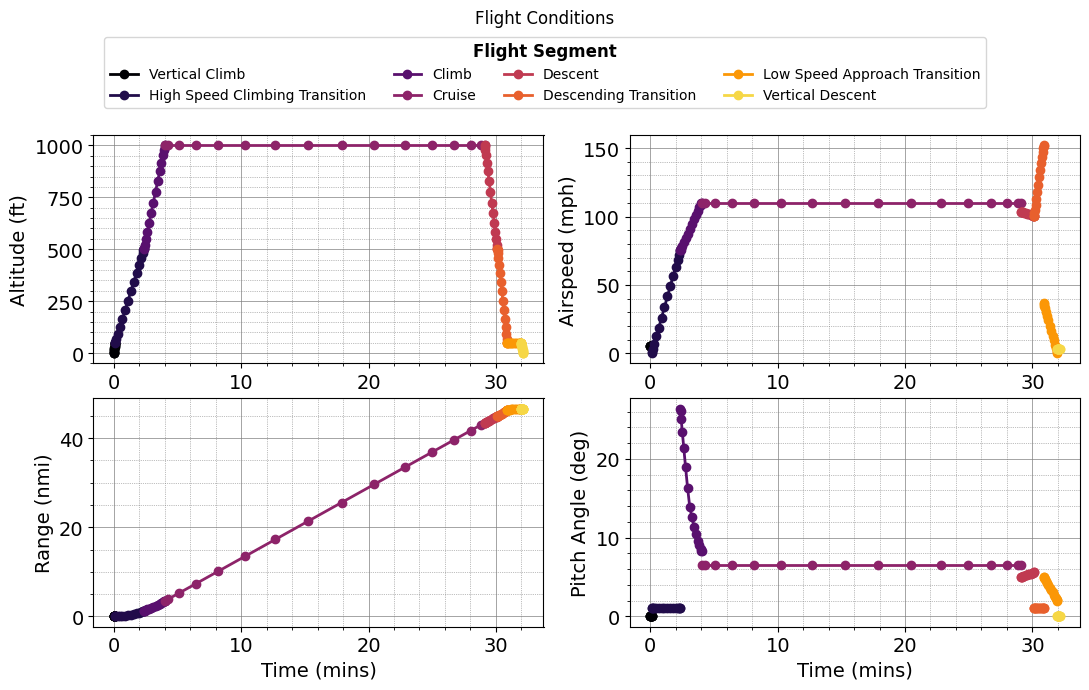

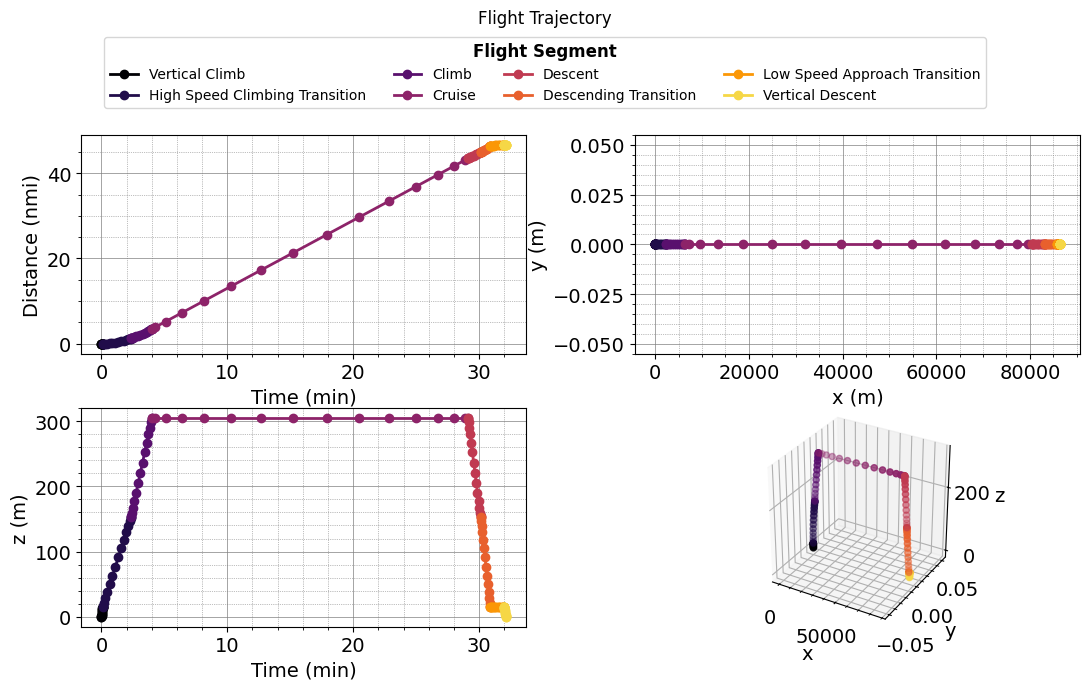

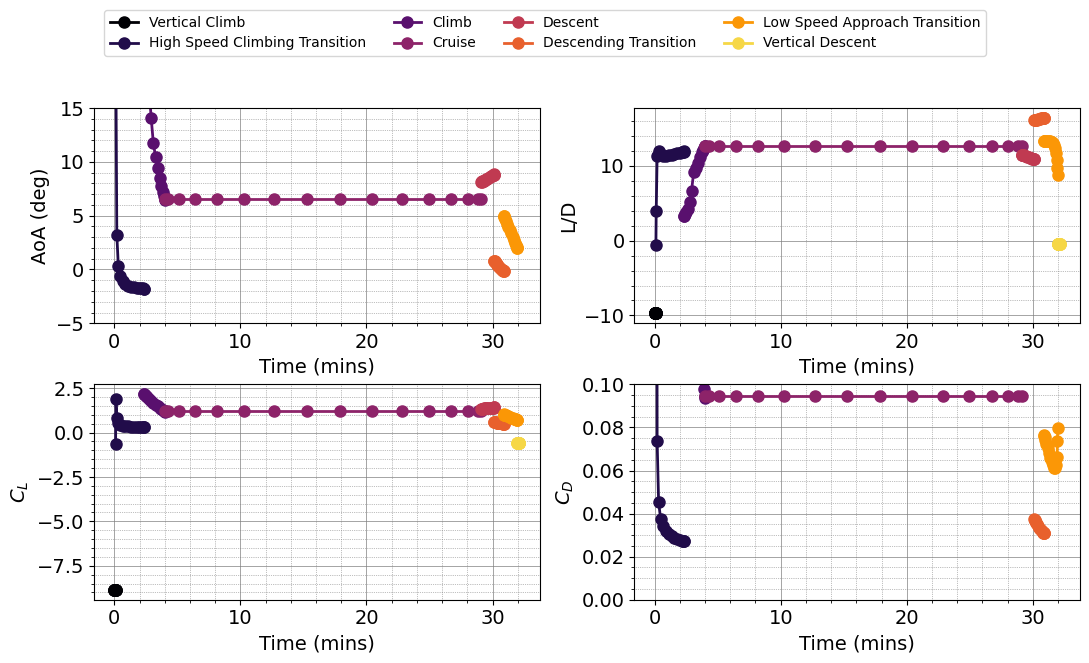

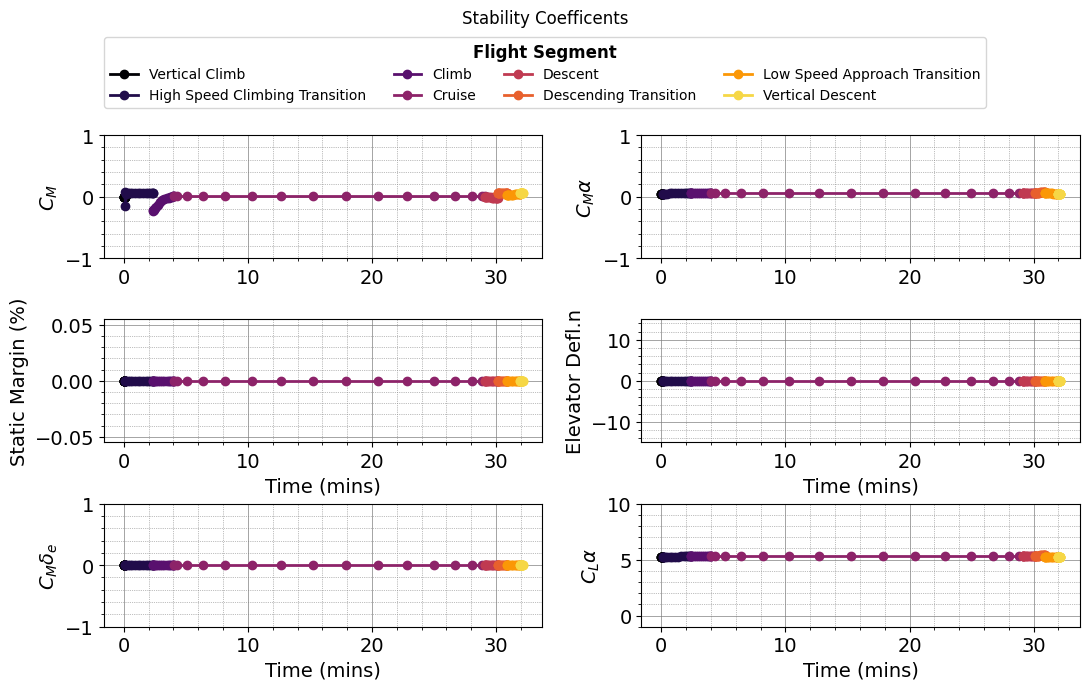

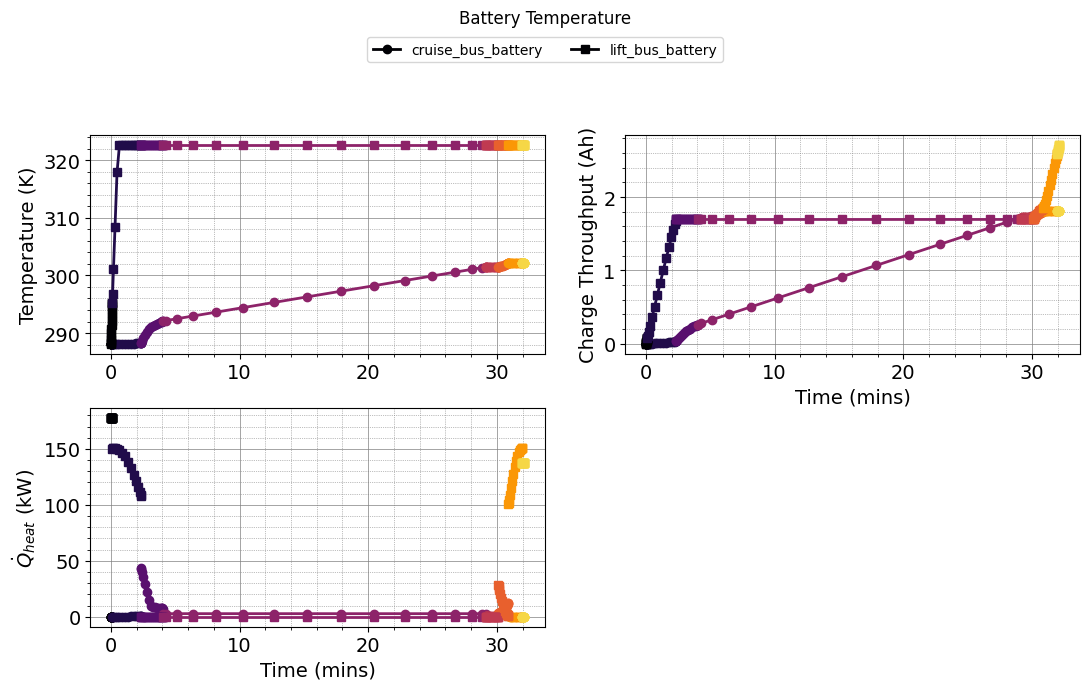

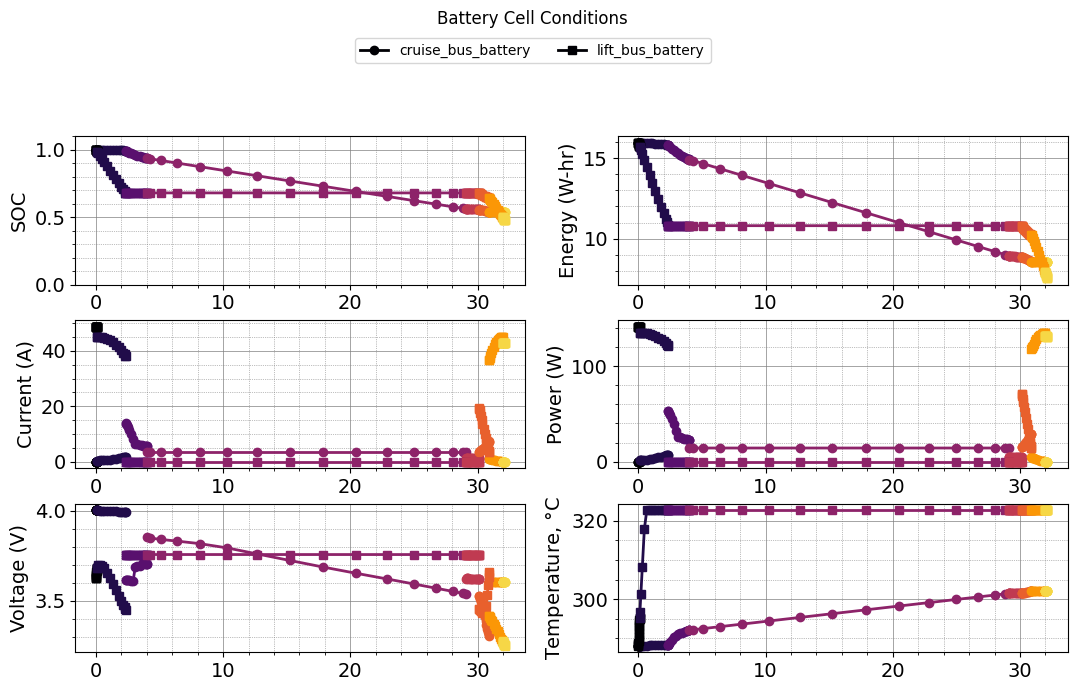

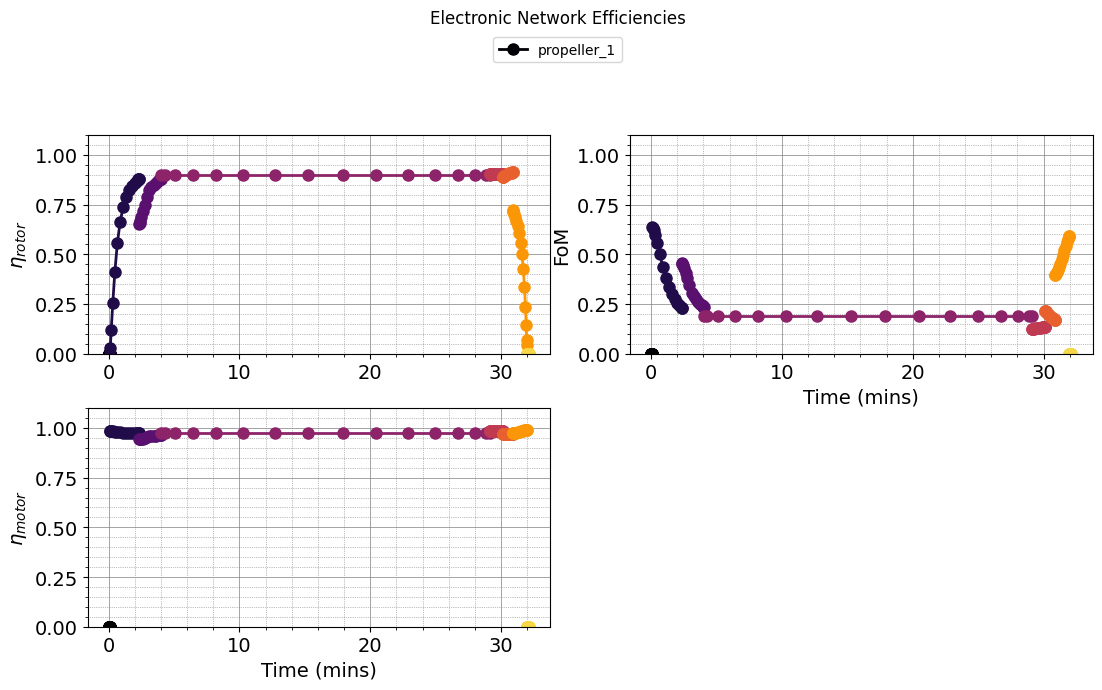

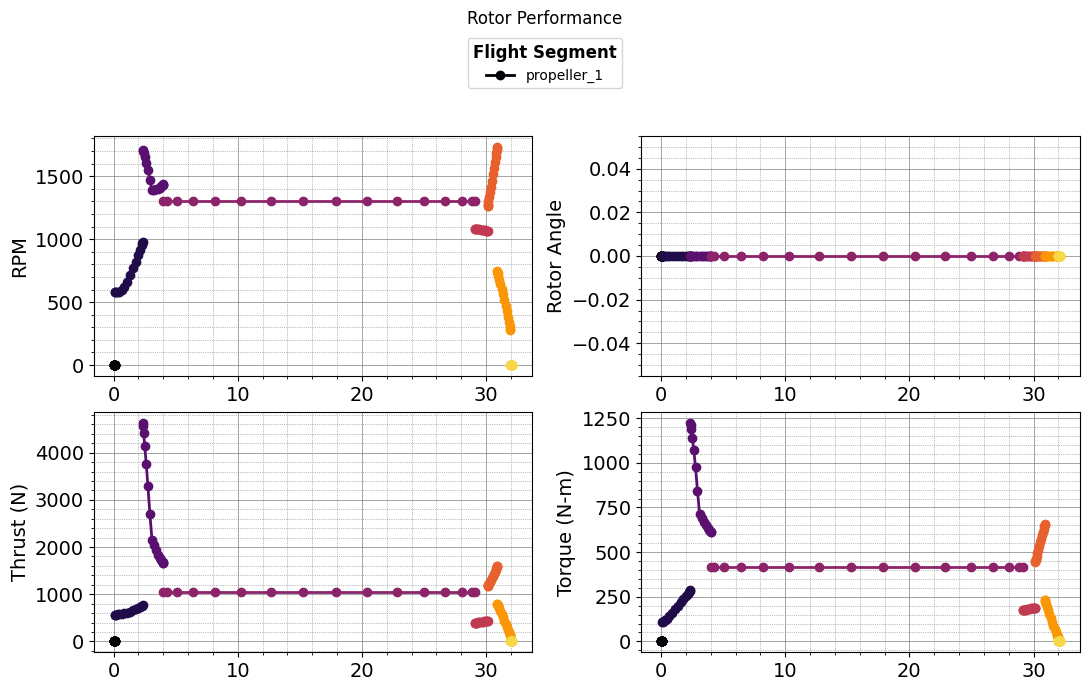

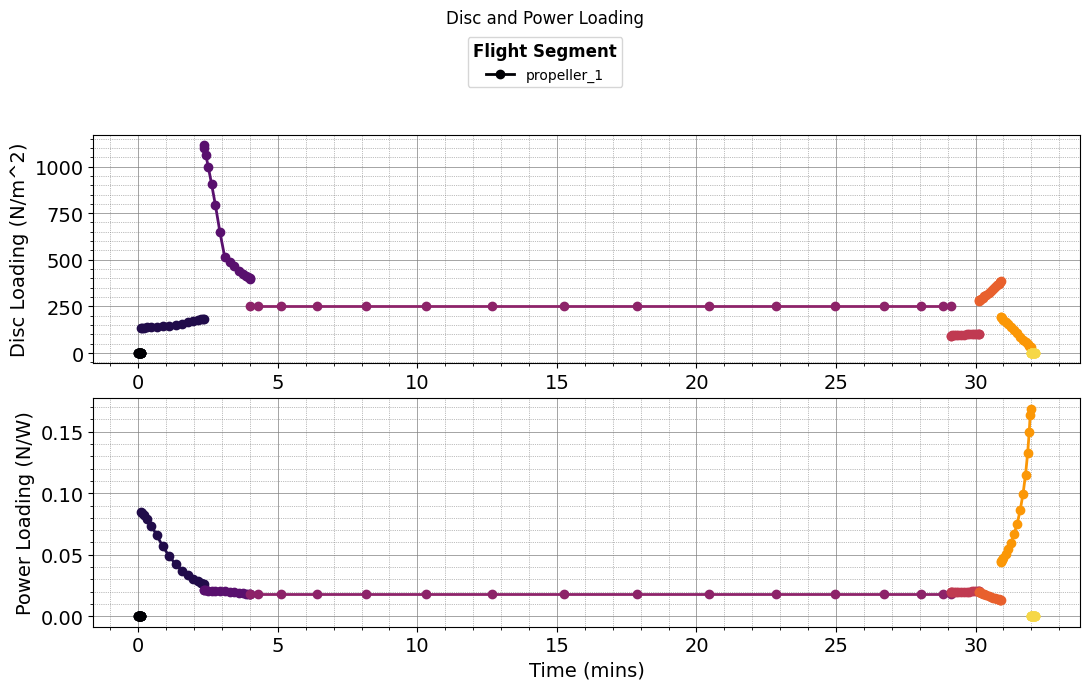

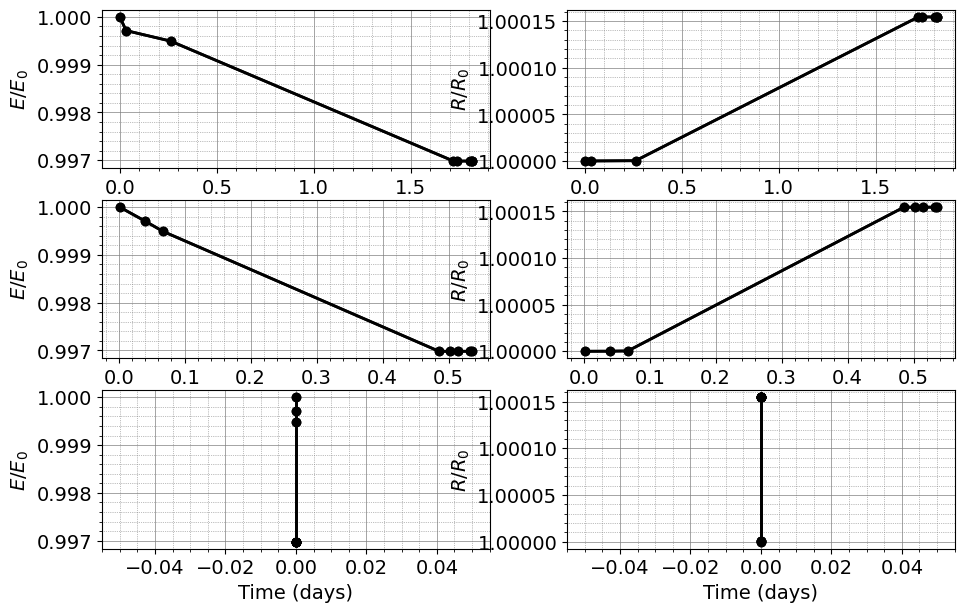

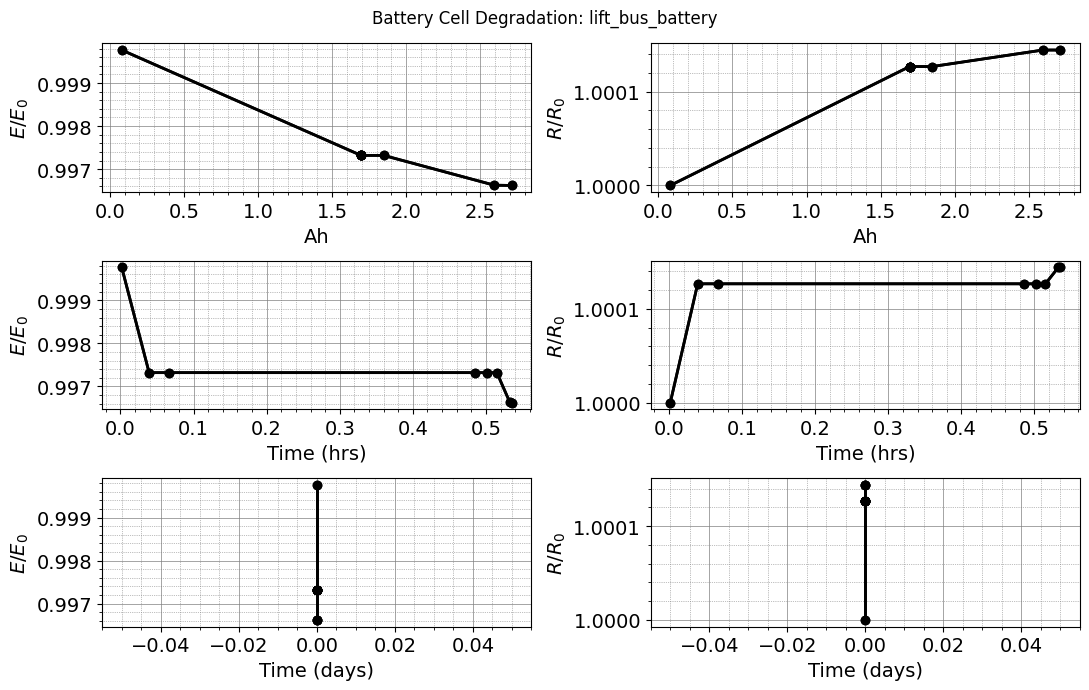

In [13]:
# vehicle data
vehicle  = vehicle_setup()

# Set up configs
configs  = configs_setup(vehicle)

# vehicle analyses
analyses = analyses_setup(configs)

# mission analyses
mission  = mission_setup(analyses)
missions = missions_setup(mission) 
    
results = missions.base_mission.evaluate() 
    
# plot the results 
plot_results(results)    

## plot vehicle 
#plot_3d_vehicle(vehicle, 
                #min_x_axis_limit            = -5,
                #max_x_axis_limit            = 15,
                #min_y_axis_limit            = -10,
                #max_y_axis_limit            = 10,
                #min_z_axis_limit            = -10,
                #max_z_axis_limit            = 10,
                #show_figure                 = False 
                #)               